In [1]:
%load_ext autoreload

%autoreload 2

import albumentations as A


from dataset import *

import numpy as np

import torch
import torchvision.models as models
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder

from utils import *
from code_eval import code

import scipy.io as sio


import sklearn.preprocessing as preprocessing
from sklearn.neighbors import KDTree


from torchvision.io import read_image 
import torchvision 
from torchvision.utils import make_grid 
from torchvision.models import EfficientNet_B3_Weights

import matplotlib.pyplot as plt


size_img = 300


data_transforms_albumentation = {
    'test': A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(size_img, size_img),
        ToTensorV2(),
    ])
}

model_file = "model_final.pth"

In [2]:
torch.cuda.set_device(2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

print("Loading datasets")

train = sio.loadmat("train_data.mat")


test = sio.loadmat("test_data.mat")


train_images = train["images"]
test_images = test["images"]


labels_train = train["irma_code"]
labels_test = test["irma_code"]


irma_train = np.vstack(train["irma_code"][0])[:, 0]
irma_test = np.vstack(test["irma_code"][0])[:, 0]

test_images = np.array(test_images)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(irma_train)
test_labels = label_encoder.transform(irma_test)


evaluator = code("codes.txt")

model = models.efficientnet_b3(weights = EfficientNet_B3_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = True
model.classifier = nn.Sequential(nn.Dropout(
    0.2), nn.Linear(in_features=1536, out_features=193))
model.to(device)

db_dataset = ImagesDataset(
    train_images, train_labels, irma_train, transform=data_transforms_albumentation["test"], albumentation=True)

db_loader = torch.utils.data.DataLoader(
    db_dataset, batch_size=8, num_workers=0)


query_dataset = ImagesDataset(
    test_images, test_labels, irma_test, transform=data_transforms_albumentation["test"], albumentation=True)

query_loader = torch.utils.data.DataLoader(
    query_dataset, batch_size=8, shuffle=False, num_workers=0)


state_dict = torch.load(model_file)

# Load the state dictionary into the model
model.load_state_dict(state_dict)



Using device: cuda
Loading datasets


<All keys matched successfully>

In [3]:
feature_extractor = nn.Sequential(model.features.eval(), model.avgpool, nn.Flatten()).to(device).eval()


features_db, targets_db = extract_features(feature_extractor, db_loader, device)

In [4]:
features_db = preprocessing.normalize(features_db, norm='l2')
kd_tree_cbir = KDTree(features_db, metric="l2")

In [5]:

features, _ = extract_features(
    feature_extractor, query_loader, device)

probs = extract_softmax(model, query_loader)

In [6]:
from utils import *

top_k = torch.tensor(np.vstack(probs)).topk(axis=1, k=2)[1]
top_k_probs = torch.tensor(np.vstack(probs)).topk(axis=1, k=2)[0]

predicted_labels = []
for i in range(0, len(probs)):
    top_k_labels = np.matrix(list(
        map(lambda n: list(label_encoder.inverse_transform([n])[0]), list(top_k[i]))))

    if (top_k_probs[i][0] < 0.7):
        predicted_labels.append(merge_labels(top_k_labels))
    else:
        predicted_labels.append(
            label_encoder.inverse_transform(top_k[i:(i+1), 0].numpy())[0])

predicted_labels[0]

'1123-127-500-000'

In [7]:
example_label_1 = "1123-127-500-000"
example_label_2 = "1124-127-500-000"
example_label_3 = "1123-117-500-000"
example_label_4 = "1123-227-500-000"
example_label_5 = "3323-327-500-100"

print(irma_similarity(example_label_1, example_label_1))
print(irma_similarity(example_label_1, example_label_2))
print(irma_similarity(example_label_1, example_label_3))
print(irma_similarity(example_label_1, example_label_4))
print(irma_similarity(example_label_1, example_label_5))

1.0
0.97
0.9318181818181819
0.8636363636363636
0.5472727272727272


In [8]:
def extract(s1, possible_labels):
    return sorted(list(map(lambda n: (n, irma_similarity(s1, n)), possible_labels)), key=lambda n: n[1], reverse=True)


possible_labels = np.vstack(np.unique(train["irma_code"][0]))[:, 0]

labels_test_irma = np.vstack(labels_test[0,])[:, 0]

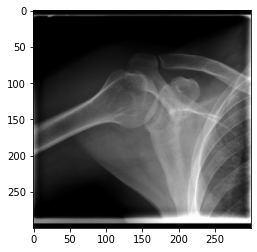

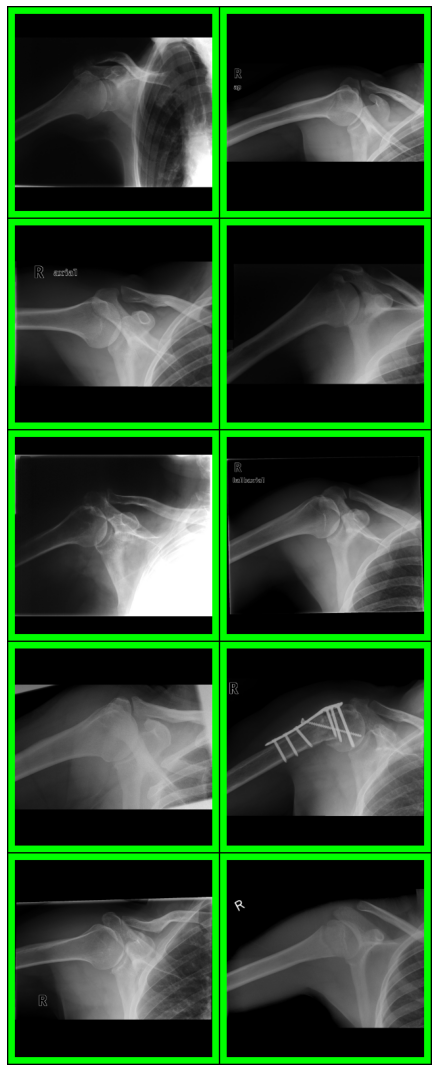

In [9]:

img_idx = 567

# Extract labels for search space shrinking
res_results = list(map(lambda n: n[0], filter(
    lambda n: n[1] >= 0.7, extract(predicted_labels[img_idx], possible_labels))))

features = preprocessing.normalize(features, norm='l2')

# Get indices and dists for features given test features
# To reduce retrieval time, decrease k
dists, indices = kd_tree_cbir.query(features[img_idx:img_idx+1], k=500)

indices = indices[0]

mask = np.in1d(labels_train[0][indices], res_results)


shrunk_labels = targets_db[indices][mask]
shrunk_features = features_db[indices][mask]


feature_similarity = 1 - (np.arccos((1 - (dists[0][mask]**2)/2))/np.pi)

categorical_similarity = np.array(list(map(lambda label: irma_similarity(
    predicted_labels[img_idx], label), label_encoder.inverse_transform(shrunk_labels))))

final_similarity = 0.5 * feature_similarity + 0.5 * categorical_similarity


retrieved_images = train_images[indices[np.argsort(final_similarity)[
    ::-1]][0:10]]

retrieved_labels = label_encoder.inverse_transform(
    train_labels[[indices[np.argsort(final_similarity)[::-1]][0:10]]][0])

retrieved_images_final = []
for i in range(0, 10):
    if (retrieved_labels[i] == labels_test_irma[img_idx]):
        retrieved_images_final.append(np.expand_dims(
            add_frame(retrieved_images[i], "green", 10), axis=0))
    else:
        retrieved_images_final.append(np.expand_dims(
            add_frame(retrieved_images[i], "red", 10), axis=0))

Grid = make_grid(torch.tensor(
    np.vstack(retrieved_images_final)).permute(0, 3, 1, 2), nrow=2)

img = torchvision.transforms.ToPILImage()(Grid)
plt.imshow(test_images[img_idx])
plt.show()

plt.figure(figsize=(20, 15))

plt.axis('off')
plt.tight_layout()

plt.imshow(img)